In [1]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.preprocessing.image import ImageDataGenerator
import keras.layers as L
import numpy
import os, random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import os
from keras.applications.mobilenet import MobileNet
from numpy.linalg import norm
import pandas as pd
import matplotlib.patches as patches
import cv2
from keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow.losses as losses
from keras.models import load_model
import math
import keras.objectives
from sklearn.model_selection import train_test_split
import keras.utils
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import urllib
from sklearn.utils import class_weight
from sklearn.preprocessing import normalize
from keras.models import load_model

/home/lenant/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lenant/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lenant/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lenant/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

In [2]:
IMAGE_SIZE=128

In [3]:
model_orig = MobileNet(weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

In [4]:
def head(m):          
#     for l in m.layers:
#         l.trainable = False
    x = m.output
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(.3)(x)
    x = L.Dense(256, activation="relu")(x)
    x = L.Dropout(.3)(x)
    x = L.Dense(3, activation="softmax")(x)
    m = Model(m.input, x)
    m.summary()
    return m
model = head(model_orig)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

In [5]:
def img_as_np_array(file_name):
    img = Image.open(file_name, 'r')
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img) / 255. - 0.5    
    return img[:,:,:3]

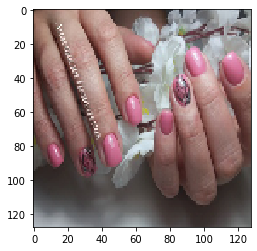

In [6]:
img = img_as_np_array("nails/0")
plt.imshow(img + .5)

In [7]:
def load_imgs(folder, limit=None, shuffle=False):
    imgs = []
    files = os.listdir(folder)
    if shuffle:
        random.shuffle(files)
    for file in files:
        img = img_as_np_array(f"{folder}/{file}")
        imgs.append(img)
        if limit is not None and len(imgs) >= limit:
            break
    imgs = np.array(imgs)
    return imgs

In [8]:
def load_opposites():
    files = []
    for i in os.walk('users'): 
        if "imgs_" in i[0]:
            for n in i[2]:                                      
                files.append(i[0] + "/" + n)
    imgs = []    
    for file in files:
        try:
            img = img_as_np_array(file)
            imgs.append(img)
        except:
            continue
    imgs = np.array(imgs)
    return imgs

In [9]:
opposites_imgs = load_opposites()
opposites_imgs.shape

(12677, 128, 128, 3)

In [10]:
nails_imgs = load_imgs("nails")
nails_imgs.shape

(1859, 128, 128, 3)

In [11]:
cakes_imgs = load_imgs("cakes")
cakes_imgs.shape

(1942, 128, 128, 3)

In [255]:
# user_folders = list(filter(lambda x: x.startswith("imgs"), os.listdir("users")))

In [12]:
# print(classification_report(np.argmax(y_test, 1), np.argmax(preds, 1)))

In [19]:
# for i, p in enumerate(preds):
#     if (np.argmax(p) == 1):
#         print(p)
#         plt.imshow(X_test[i] + .5)
#         plt.show()

In [24]:
model.compile(optimizer=keras.optimizers.Adam(lr = 0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )

In [31]:
for _ in range(100):
    half_size = int(max(len(nails_imgs), len(cakes_imgs)) / 2)
    imagenet_imgs = load_imgs("../groceries-model/imagenet224", half_size, True)
    opposites = random.choices(opposites_imgs, k=half_size)
#     print(half_size, len(imagenet_imgs), len(opposites))
    X = np.vstack((imagenet_imgs, opposites, nails_imgs, cakes_imgs))
    Y = np.hstack(
        (np.zeros(len(imagenet_imgs)), 
         np.zeros(len(opposites)),
         np.ones(len(nails_imgs)), 
         np.array([2]*len(cakes_imgs))))
    Y_hot = to_categorical(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y_hot, test_size=0.1, random_state=2)
    
#     class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=64,
#               class_weight=class_weights
                   callbacks=[keras.callbacks.ModelCheckpoint(
                       "checkpoints/0_nails_cakes_unb_{epoch:02d}_va{val_acc:.4f}.h5")],
                   )

Train on 3897 samples, validate on 433 samples
Epoch 1/1
3897/3897 [==============================] - 6s 1ms/step - loss: 0.0453 - acc: 0.9867 - val_loss: 0.1865 - val_acc: 0.9538
Train on 3897 samples, validate on 433 samples
Epoch 1/1
3897/3897 [==============================] - 6s 2ms/step - loss: 0.0250 - acc: 0.9905 - val_loss: 0.1097 - val_acc: 0.9815
Train on 3897 samples, validate on 433 samples
Epoch 1/1
3897/3897 [==============================] - 6s 1ms/step - loss: 0.0150 - acc: 0.9949 - val_loss: 0.2385 - val_acc: 0.9561
Train on 3897 samples, validate on 433 samples
Epoch 1/1
3897/3897 [==============================] - 6s 1ms/step - loss: 0.0160 - acc: 0.9954 - val_loss: 0.1403 - val_acc: 0.9561
Train on 3897 samples, validate on 433 samples
Epoch 1/1
1024/3897 [======>.......................] - ETA: 3s - loss: 0.0384 - acc: 0.9893

KeyboardInterrupt: 

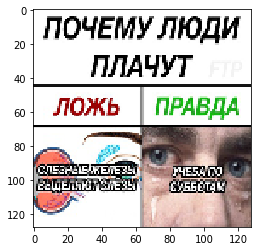

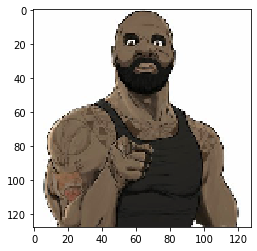

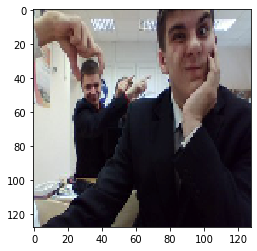

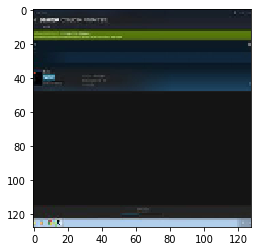

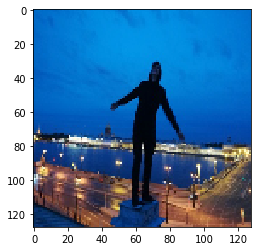

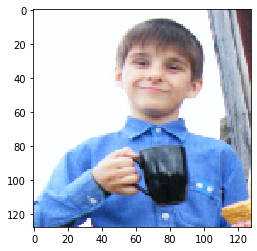

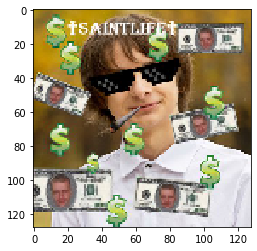

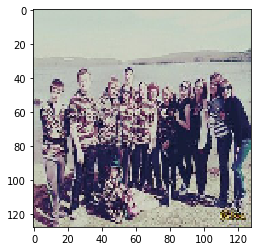

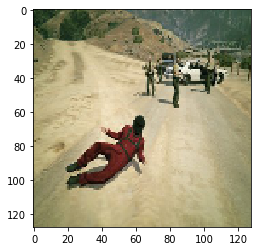

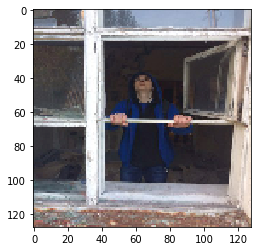

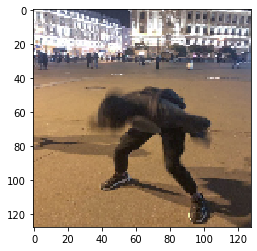

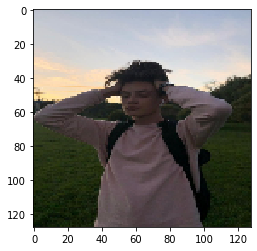

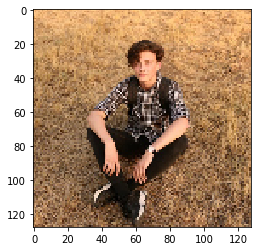

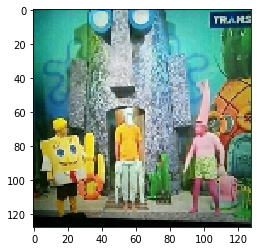

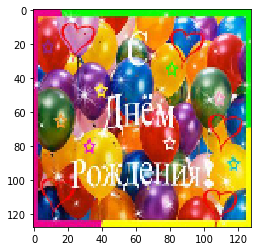

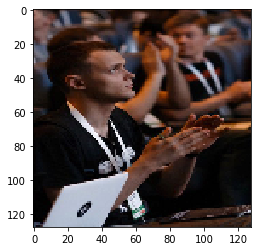

KeyboardInterrupt: 

In [300]:
for i in opposites_imgs:
    plt.imshow(i + .5)
    plt.show()

In [32]:
user_folders = list(filter(lambda x: x.startswith("imgs"), os.listdir("users")))

1 [2.5218147e-01 7.4777019e-01 4.8278700e-05]


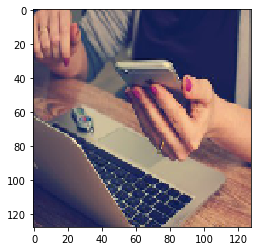

2 [2.2758009e-01 1.2041243e-04 7.7229947e-01]


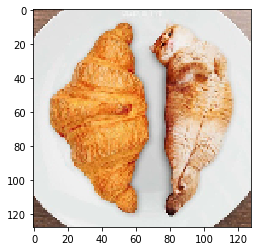

2 [0.49551818 0.00186517 0.5026167 ]


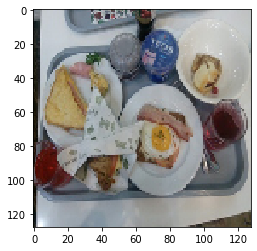

2 [2.3825867e-01 2.8863515e-05 7.6171243e-01]


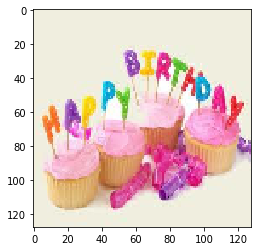

1 [0.09111405 0.8867036  0.02218238]


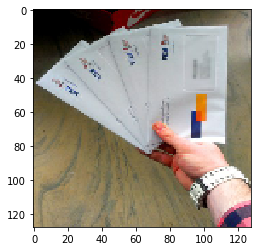

2 [4.5000899e-01 1.3147015e-04 5.4985958e-01]


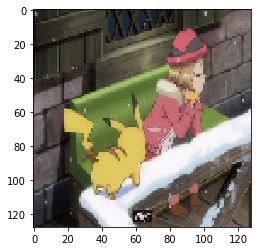

2 [4.9956331e-01 4.0470983e-04 5.0003201e-01]


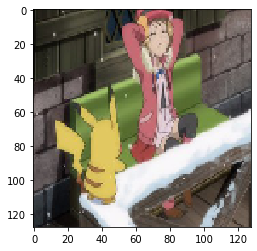

2 [0.42602092 0.0014294  0.5725497 ]


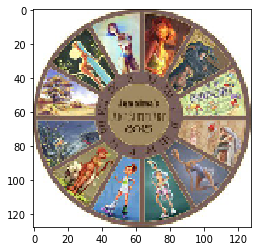

2 [0.22762382 0.00137854 0.7709976 ]


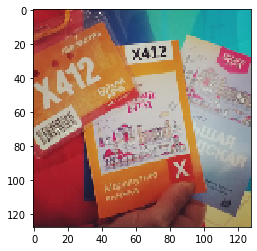

2 [1.0618065e-01 1.7533045e-04 8.9364403e-01]


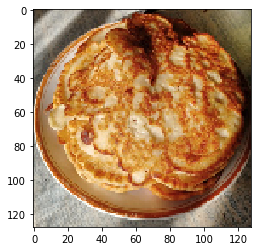

1 [0.486258   0.51270056 0.00104147]


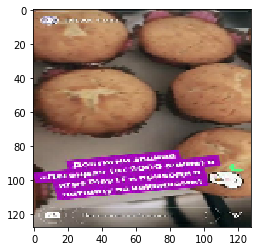

2 [3.6457115e-01 1.7210886e-04 6.3525683e-01]


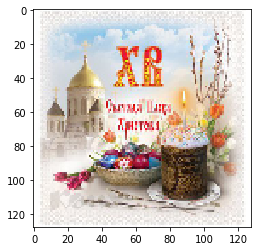

2 [4.9422631e-01 4.5971968e-04 5.0531399e-01]


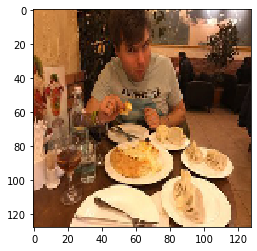

2 [1.40020013e-01 1.13472706e-04 8.59866500e-01]


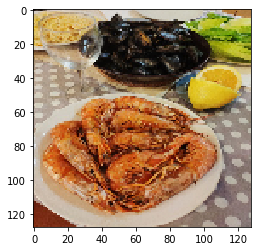

2 [0.45625368 0.00641691 0.5373294 ]


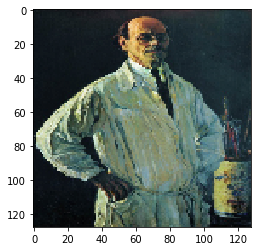

2 [3.7821826e-01 5.2296621e-04 6.2125880e-01]


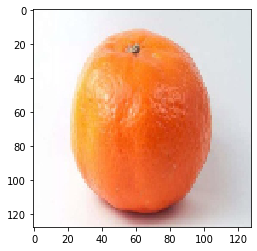

1 [3.8956596e-08 1.0000000e+00 9.4908952e-09]


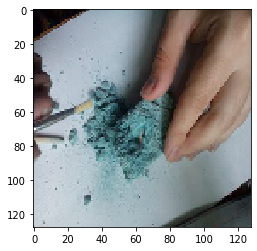

2 [5.8498885e-04 4.8070891e-11 9.9941504e-01]


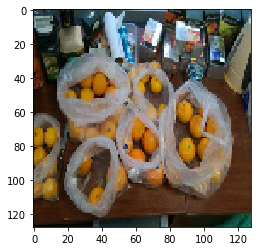

2 [1.5298007e-01 4.0882810e-06 8.4701586e-01]


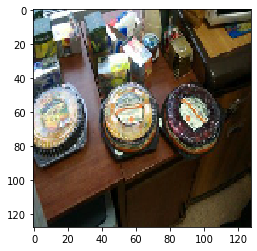

2 [7.6494776e-02 5.7832395e-08 9.2350513e-01]


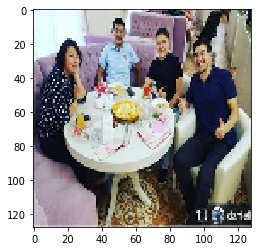

2 [1.8154697e-02 1.5556138e-07 9.8184514e-01]


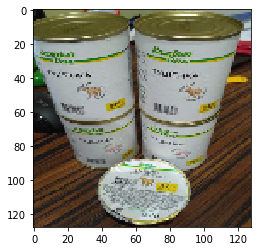

2 [4.480665e-01 4.890071e-04 5.514444e-01]


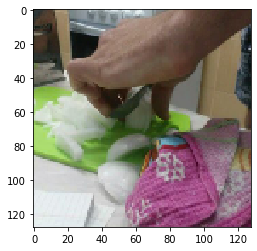

2 [0.39198744 0.00169699 0.6063155 ]


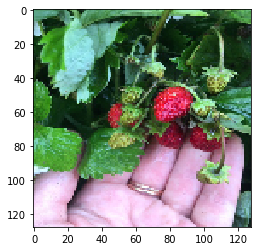

2 [2.6272513e-02 2.6427083e-08 9.7372752e-01]


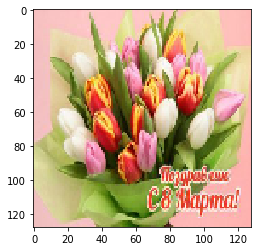

2 [1.5831004e-01 2.6456642e-04 8.4142536e-01]


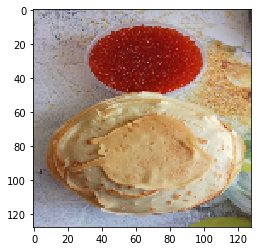

2 [0.23802993 0.0016815  0.7602886 ]


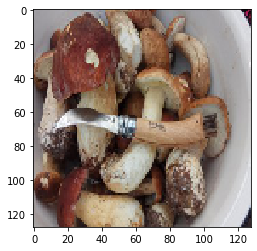

2 [4.9496503e-03 2.7613961e-08 9.9505037e-01]


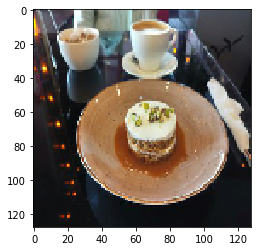

1 [5.0159511e-03 9.9418616e-01 7.9789117e-04]


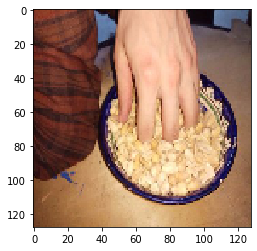

2 [3.6670032e-01 3.5693884e-04 6.3294274e-01]


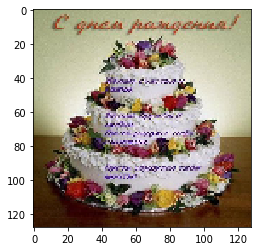

2 [9.075486e-02 3.000278e-04 9.089451e-01]


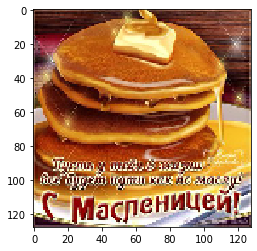

In [33]:
for f in user_folders:
    try:
        imgs = load_imgs(f"users/{f}", 64)
    except:
        continue
#     print(imgs.shape)
#     break
#     for img in imgs:
#         plt.imshow(img + .5)
#         plt.show()
    preds = model.predict(imgs)
#     print(np.argmax(preds, 1))
#     print(preds)
    for i, p in enumerate(preds):        
        if (np.argmax(p) > 0):
            print(np.argmax(p), p)
            plt.imshow(imgs[i] + .5)
            plt.show()
#     break

In [48]:
a = [1,2,3]
np.array(a) / sum(a)

array([0.16666667, 0.33333333, 0.5       ])

In [6]:
model = load_model("checkpoints/0_nails_cakes_unb_01_va0.9561.h5")







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[[1.4391058e-10 1.0000000e+00 1.8690429e-09]] 1


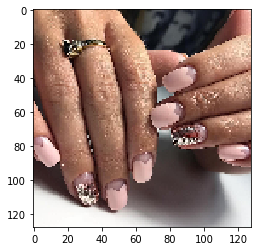

In [23]:
url = "https://sun9-62.userapi.com/c858432/v858432253/88065/8DBnSLLR7FA.jpg"
urllib.request.urlretrieve(
    url, 
    f"tmp")

img = img_as_np_array("tmp")
plt.imshow(img + .5)

preds = model.predict(img[None,:]) 
print(preds, np.argmax(preds))

In [32]:
# imagenet_imgs = []
# imagenet_files = os.listdir("../groceries-model/imagenet224")
# random.shuffle(imagenet_files)
# for i, file in enumerate(imagenet_files):
#     img = img_as_np_array(f"../groceries-model/imagenet224/{file}")
#     imagenet_imgs.append(img)
#     if i >= nails_imgs.shape[0]:
#         break
# imagenet_imgs = np.array(imagenet_imgs)